In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import cv2
import numpy as np
from numpy import *
import scipy.signal 
from scipy import stats
from scipy.spatial import distance

folder = r'C:\Users\fr87_\Documents\Python code\Input folder\arena 1 translation'
output_folder=r'C:\Users\fr87_\Documents\Python code\Output folder'

def sandwell_loc(behavioural_video):
    """Identify Sandwell locations and radii from first frame

    INPUT
    - Behavioural video
    
    OUTPUT
    - Sandwell locations for: sw1, sw2, sw3"""
    
    # Read in first video frame
    cap = cv2.VideoCapture(behavioural_video)
    correct_sandwell = 'n'
    frame=1
    while correct_sandwell != 'y':
        img = cap.read()[1] # Read in Pixel values
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        gray_blurred = cv2.blur(gray, (3, 3)) 

        # Circle detection algorithm
        sandwells = cv2.HoughCircles(gray_blurred,  
                           cv2.HOUGH_GRADIENT, 1, 100, param1 = 50, 
                       param2 = 30, minRadius = 10, maxRadius = 20)
        if sandwells is not None:
            # Convert the circle parameters a, b and r to integers. 
            sandwells = np.uint16(np.around(sandwells)) 
        
        # Manually check that sandwells are correct
        if frame == 1 or frame % 100 == 0:
            for pt in sandwells[0, :]: 
                x, y, r = pt[0], pt[1], pt[2]
                cv2.circle(img, (x, y), r+20, (0, 255, 0), 2)
                
            avg_dis = np.mean(distance.cdist(sandwells[0][:,:2], sandwells[0][:,:2], 'euclidean'))
            if len(sandwells[0])==3 and avg_dis < 130:
                %matplotlib inline
                plt.imshow(img) 
                plt.show()
                correct_sandwell = input("Are all sandwells correct - y/n?")
                frame+=1
            else:
                correct_sandwell = 'n'
                frame+=1
        else:
            frame+=1
            
        # Classify which sandwell is sw1, sw2, sw3
        for pt in sandwells[0, :]: 
            x, y = pt[0], pt[1]
            if y == min(np.array(sandwells).transpose()[1]):
                sw1 = [float(x),float(y)]
            elif x == max(np.array(sandwells).transpose()[0]):
                sw2 = [float(x),float(y)]
            else:
                sw3 = [float(x),float(y)]
    print(len(sandwells[0]),'Wells correctly detected')
    return sw1,sw2,sw3



In [144]:
def coordinate_change(folder, file):
    """
    file=name of the file
    
    The BEH.flv video and the DLC.csv need to be in the same folder
    
    This function will change coordinates using the 3 sandwells as reference points.
    
    The resulting DLC file will be translated so that the North-West corner has coordinates (0,0)
    
    ----------------------------------------
    
    if the difference between the x position of SW1 and SW3 is greater than 5 pixels (roughly 1 cm) the arena is considered aligned. 
    
    otherwise, the x, y copordinates are rotated
    
    so that   X* = ( R ) . X
    
               |  11   12  |   |  cos(a)   -sin(a)  |
    where  R = |           | = |                    |    
               |  21   22  |   |  sin(a)    cos(a)  |
               
    This is the general case of the simple translation where R=(1 0; 0 1)
    
    """
    #definition of the associated BEH and DLC files
    
    BEH_video= os.path.join(folder, file +'_BEH.flv')
    DLC_file= os.path.join(folder, file + '_DLC.csv')
    
    # sandwell_loc extract sandwells position (WARNING!!!! avoid frames where the cable is within a SW radius as this 
    # will result in imprecise centre detection. In this case simply answer 'no' and move on to the next displyed frame
    
    sandwells= sandwell_loc(BEH_video)
    
    DLC_data=pd.read_csv(DLC_file, sep=',', index_col=0)
    
    # definition of the new origin. This will have the North-West corner set at (0,0)
    
    NEW_ARENA_CORNERS=([-99.6,-27.5], [220.4,-27.5], [-99.6,292.5], [220.4,292.5])

    if abs(sandwells[2][0] - sandwells[0][0]) <= 5 :
        DLC_data['x_translated']=DLC_data['x']-sandwells[0][0]-NEW_ARENA_CORNERS[0][0]
        DLC_data['y_translated']=DLC_data['y']-sandwells[0][1]-NEW_ARENA_CORNERS[0][1]
        
        print("%s .......The arena has not been rotated" % file )

    else:

        #calculates cos and sin value of the angle between SW3 and SW1 which is used to rotate

        COS_A= (sandwells[2][1] - sandwells[0][1])/math.sqrt((sandwells[0][1] - sandwells[2][1])**2 + (sandwells[0][0] - sandwells[2][0])**2)
        SIN_A= (sandwells[2][0] - sandwells[0][0])/math.sqrt((sandwells[0][1] - sandwells[2][1])**2 + (sandwells[0][0] - sandwells[2][0])**2)

        DLC_data['x_translated']=DLC_data.apply(lambda z: (z['x']-sandwells[0][0])*COS_A - (z['y']-sandwells[0][1])*SIN_A + sandwells[0][0], axis = 1)
        DLC_data['y_translated']=DLC_data.apply(lambda z: +(z['x']-sandwells[0][0])*SIN_A + (z['y']-sandwells[0][1])*COS_A +sandwells[0][1], axis = 1)

        print("%s .......The arena has been rotated by" % file, np.degrees(np.arcsin(SIN_A)), "degrees" )

        DLC_data['x_translated']=DLC_data['x_translated']-sandwells[0][0]-NEW_ARENA_CORNERS[0][0]
        DLC_data['y_translated']=DLC_data['y_translated']-sandwells[0][1]-NEW_ARENA_CORNERS[0][1]
        

    return DLC_data

Analysing  H2202_A01_SW3_PRE


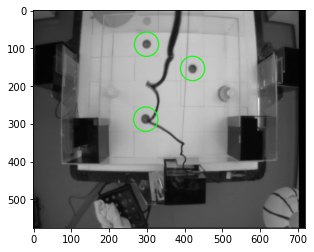

Are all sandwells correct - y/n?n


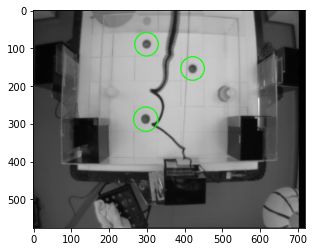

Are all sandwells correct - y/n?y
3 Wells correctly detected
H2202_A01_SW3_PRE .......The arena has not been rotated


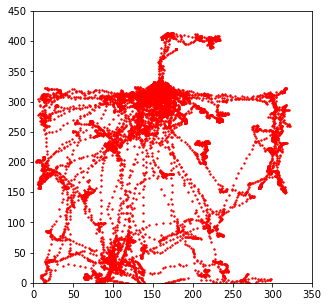

                x          y  x_translated  y_translated
scorer                                                  
0       380.00000  450.00000     179.60000     387.50000
1       380.00000  450.00000     179.60000     387.50000
2       380.00000  450.00000     179.60000     387.50000
3       380.00000  450.00000     179.60000     387.50000
4       380.00000  450.00000     179.60000     387.50000
...           ...        ...           ...           ...
18458   362.21417  466.07194     161.81417     403.57194
18459   362.21417  466.07194     161.81417     403.57194
18460   362.21417  466.07194     161.81417     403.57194
18461   362.21417  466.07194     161.81417     403.57194
18462   362.21417  466.07194     161.81417     403.57194

[18463 rows x 4 columns]
Analysing  H2202_A01_SW3_SAM


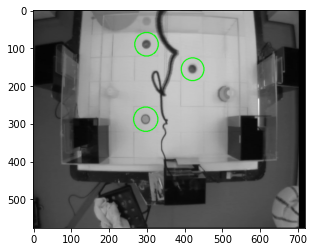

Are all sandwells correct - y/n?y
3 Wells correctly detected
H2202_A01_SW3_SAM .......The arena has not been rotated


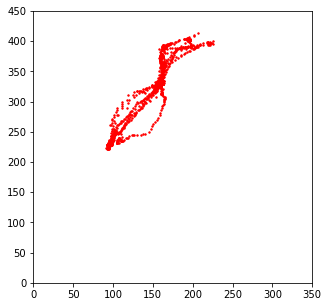

                 x           y  x_translated  y_translated
scorer                                                    
0       380.000000  450.000000    179.600000    387.500000
1       380.000000  450.000000    179.600000    387.500000
2       380.000000  450.000000    179.600000    387.500000
3       380.000000  450.000000    179.600000    387.500000
4       380.000000  450.000000    179.600000    387.500000
...            ...         ...           ...           ...
9015    363.213951  435.587378    162.813951    373.087378
9016    363.015007  435.679868    162.615007    373.179868
9017    363.052349  435.666178    162.652349    373.166178
9018    363.019453  435.660712    162.619453    373.160712
9019    362.861783  435.747293    162.461783    373.247293

[9020 rows x 4 columns]


In [152]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

folder = r'C:\Users\fr87_\Documents\Python code\Input folder\arena 1 translation'

for folder, subfolder, items in os.walk(folder):
    for file in items:
        if file[-7:]=='DLC.csv':
            plt.close()
            file = file[:-8]
            print('Analysing ', file)
            df_output=coordinate_change(folder, file)
            plt.figure(figsize=(5,5))
            plt.xlim((0, 350))
            plt.ylim((0, 450))
            plt.scatter(df_output['x_translated'], df_output['y_translated'], s=2, c='red')
            plt.show()
            print(df_output)
            #df_output.to_csv(os.path.join(folder, file + _DLC_translated.csv), sep=';')

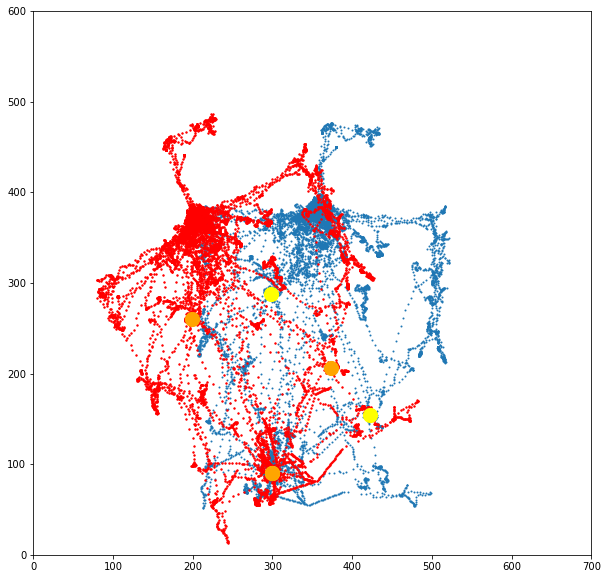

In [150]:
file = 'H2202_A01_SW3_PRE'

DLC_file= os.path.join(folder, file + '_DLC.csv')

DLC_data=pd.read_csv(DLC_file, sep=',', index_col=0)

sandwells2=pd.DataFrame({'x':[300.0,422,298], 'y':[ 90.0,154.0,288.0]})

COS_A= math.cos(np.pi/6)
SIN_A= math.sin(np.pi/6)


DLC_data['x1']=DLC_data.apply(lambda z: (z['x']-sandwells[0][0])*COS_A - (z['y']-sandwells[0][1])*SIN_A +sandwells[0][0], axis = 1)
DLC_data['y1']=DLC_data.apply(lambda z: (z['x']-sandwells[0][0])*SIN_A + (z['y']-sandwells[0][1])*COS_A +sandwells[0][1], axis = 1)

sandwells2['x1']=sandwells2.apply(lambda z: (z['x']-sandwells[0][0])*COS_A - (z['y']-sandwells[0][1])*SIN_A +sandwells[0][0], axis = 1)
sandwells2['y1']=sandwells2.apply(lambda z: (z['x']-sandwells[0][0])*SIN_A + (z['y']-sandwells[0][1])*COS_A +sandwells[0][1], axis = 1)


plt.figure(figsize=(10,10))
plt.scatter(DLC_data['x'], DLC_data['y'], s=1)
plt.scatter(DLC_data['x1'], DLC_data['y1'], s=2, c='red')
plt.scatter(sandwells2['x'], sandwells2['y'], s=200, c='yellow')
plt.scatter(sandwells2['x1'], sandwells2['y1'], s=200, c='orange')


plt.xlim((0, 700))
plt.ylim((0, 600));

In [153]:
99.6+

320.0

# Example no rotation

Arena has not been rotated


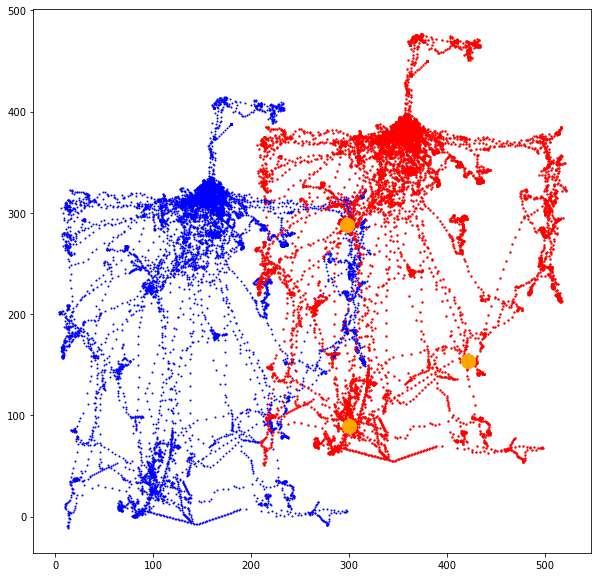

In [151]:
sandwells=([300.0, 90.0], [422.0, 154.0], [298.0, 288.0])
DLC_data=pd.read_csv(DLC_file, sep=',', index_col=0)

NEW_ARENA_CORNERS=([-99.6,-27.5], [220.4,-27.5], [-99.6,292.5], [220.4,292.5])

if abs(sandwells[2][0] - sandwells[0][0]) <= 5 :
    DLC_data['x_translated']=DLC_data['x']-sandwells[0][0]-NEW_ARENA_CORNERS[0][0]
    DLC_data['y_translated']=DLC_data['y']-sandwells[0][1]-NEW_ARENA_CORNERS[0][1]
    
    print("Arena has not been rotated")

else:
    
    #calculates cos and sin value of the angle between SW3 and SW1 which is used to rotate
        
    COS_A= (sandwells[2][1] - sandwells[0][1])/math.sqrt((sandwells[0][1] - sandwells[2][1])**2 + (sandwells[0][0] - sandwells[2][0])**2)
    SIN_A= (sandwells[2][0] - sandwells[0][0])/math.sqrt((sandwells[0][1] - sandwells[2][1])**2 + (sandwells[0][0] - sandwells[2][0])**2)
       
    DLC_data['x_translated']=DLC_data.apply(lambda z: (z['x']-sandwells[0][0])*COS_A - (z['y']-sandwells[0][1])*SIN_A + sandwells[0][0], axis = 1)
    DLC_data['y_translated']=DLC_data.apply(lambda z: +(z['x']-sandwells[0][0])*SIN_A + (z['y']-sandwells[0][1])*COS_A +sandwells[0][1], axis = 1)

    print("Arena has been rotated by", np.degrees(np.arcsin(SIN_A)), "degrees" )
    
    DLC_data['x_translated']=DLC_data['x_translated']-sandwells[0][0]-NEW_ARENA_CORNERS[0][0]
    DLC_data['y_translated']=DLC_data['y_translated']-sandwells[0][1]-NEW_ARENA_CORNERS[0][1]

    
plt.figure(figsize=(10,10))
plt.scatter(DLC_data['x_translated'], DLC_data['y_translated'], s=1, c= 'blue')
plt.scatter(DLC_data['x'], DLC_data['y'], s=2, c='red')
plt.scatter(sandwells2['x'], sandwells2['y'], s=200, c='orange')


# Example with rotation

(0.0, 600.0)

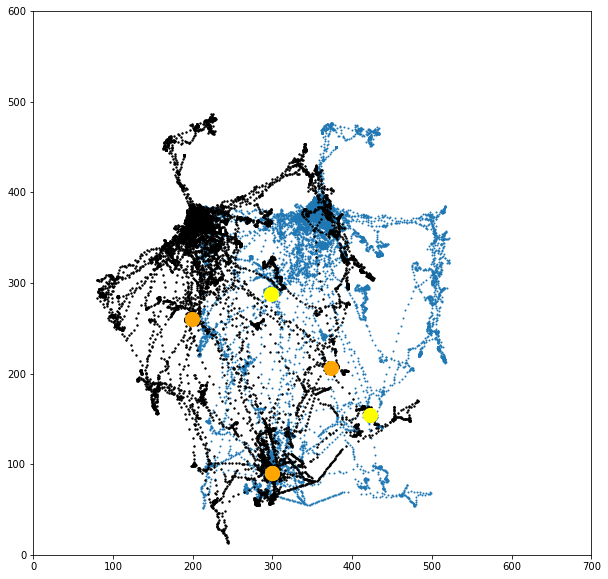

In [105]:
DLC_data=pd.read_csv(DLC_file, sep=',', index_col=0)

sandwells2=pd.DataFrame({'x':[300.0,422,298], 'y':[ 90.0,154.0,288.0]})

COS_A= math.cos(np.pi/6)
SIN_A= math.sin(np.pi/6)


DLC_data['x1']=DLC_data.apply(lambda z: (z['x']-sandwells[0][0])*COS_A - (z['y']-sandwells[0][1])*SIN_A +sandwells[0][0], axis = 1)
DLC_data['y1']=DLC_data.apply(lambda z: (z['x']-sandwells[0][0])*SIN_A + (z['y']-sandwells[0][1])*COS_A +sandwells[0][1], axis = 1)

sandwells2['x1']=sandwells2.apply(lambda z: (z['x']-sandwells[0][0])*COS_A - (z['y']-sandwells[0][1])*SIN_A +sandwells[0][0], axis = 1)
sandwells2['y1']=sandwells2.apply(lambda z: (z['x']-sandwells[0][0])*SIN_A + (z['y']-sandwells[0][1])*COS_A +sandwells[0][1], axis = 1)


plt.figure(figsize=(10,10))
plt.scatter(DLC_data['x'], DLC_data['y'], s=1)
plt.scatter(DLC_data['x1'], DLC_data['y1'], s=2, c='k')
plt.scatter(sandwells2['x'], sandwells2['y'], s=200, c='yellow')
plt.scatter(sandwells2['x1'], sandwells2['y1'], s=200, c='orange')


plt.xlim((0, 700))
plt.ylim((0, 600))

In [106]:
DLC_data['x']=DLC_data['x1']
DLC_data['y']=DLC_data['y1']

In [107]:
sandwells2

,x,y,x1,y1
0,300.0,90.0,300.000000,90.000000
1,422.0,154.0,373.655099,206.425626
2,298.0,288.0,199.267949,260.473030


Arena has been rotated by -30.578725606085257 degrees


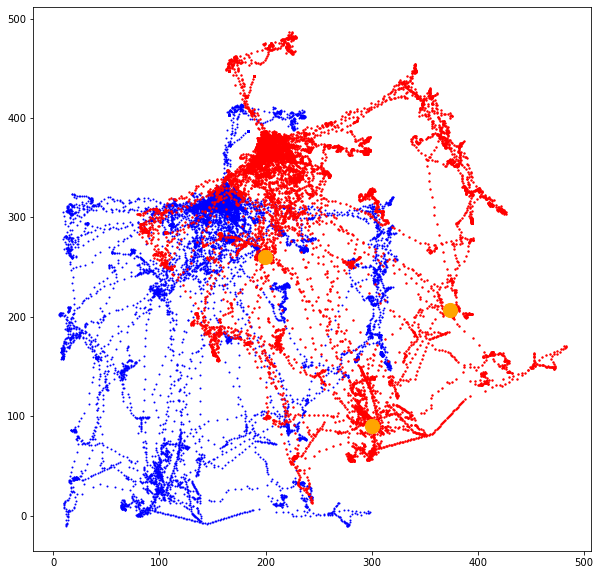

In [108]:

sandwells=([300.000000 ,  90.000000 ],[373.655099 , 206.425626 ], [199.267949,  260.473030])

NEW_ARENA_CORNERS=([-99.6,-27.5], [220.4,-27.5], [-99.6,292.5], [220.4,292.5])

if abs(sandwells[2][0] - sandwells[0][0]) <= 5 :
    DLC_data['x_translated']=DLC_data['x']-sandwells[0][0]-NEW_ARENA_CORNERS[0][0]
    DLC_data['y_translated']=DLC_data['y']-sandwells[0][1]-NEW_ARENA_CORNERS[0][1]
    
    print("Arena has not been rotated")

else:
    
    #calculates cos and sin value of the angle between SW3 and SW1 which is used to rotate
        
    COS_A= (sandwells[2][1] - sandwells[0][1])/math.sqrt((sandwells[0][1] - sandwells[2][1])**2 + (sandwells[0][0] - sandwells[2][0])**2)
    SIN_A= (sandwells[2][0] - sandwells[0][0])/math.sqrt((sandwells[0][1] - sandwells[2][1])**2 + (sandwells[0][0] - sandwells[2][0])**2)
       
    DLC_data['x_translated']=DLC_data.apply(lambda z: (z['x']-sandwells[0][0])*COS_A - (z['y']-sandwells[0][1])*SIN_A + sandwells[0][0], axis = 1)
    DLC_data['y_translated']=DLC_data.apply(lambda z: (z['x']-sandwells[0][0])*SIN_A + (z['y']-sandwells[0][1])*COS_A +sandwells[0][1], axis = 1)

    print("Arena has been rotated by", np.degrees(np.arcsin(SIN_A)), "degrees" )
    
    DLC_data['x_translated']=DLC_data['x_translated']-sandwells[0][0]-NEW_ARENA_CORNERS[0][0]
    DLC_data['y_translated']=DLC_data['y_translated']-sandwells[0][1]-NEW_ARENA_CORNERS[0][1]

    
plt.figure(figsize=(10,10))
plt.scatter(DLC_data['x_translated'], DLC_data['y_translated'], s=1, c= 'blue')
plt.scatter(DLC_data['x'], DLC_data['y'], s=2, c='red')
plt.scatter(sandwells2['x1'], sandwells2['y1'], s=200, c='orange')

